In [79]:
# Core
import os
import numpy as np
import pandas as pd

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing & ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Time Series
from statsmodels.tsa.arima.model import ARIMA

# Advanced Models
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter Tuning
from skopt import BayesSearchCV

# Explainability
import shap
import lime
import lime.lime_tabular

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [80]:


# Set path
path = r"C:\Users\neeha\Downloads\solar_data"

# Load all datasets
plant_1_gen = pd.read_csv(os.path.join(path, "Plant_1_Generation_Data.csv"))
plant_2_gen = pd.read_csv(os.path.join(path, "Plant_2_Generation_Data.csv"))
plant_1_weather = pd.read_csv(os.path.join(path, "Plant_1_Weather_Sensor_Data.csv"))
plant_2_weather = pd.read_csv(os.path.join(path, "Plant_2_Weather_Sensor_Data.csv"))

# Confirm successful load
print("Dataset Shapes:")
print("Plant 1 Gen:", plant_1_gen.shape)
print("Plant 2 Gen:", plant_2_gen.shape)
print("Plant 1 Weather:", plant_1_weather.shape)
print("Plant 2 Weather:", plant_2_weather.shape)

# Print top 10 rows of each dataset
print("\nTop 10 rows - Plant 1 Generation Data:")
print(plant_1_gen.head(10).to_string(index=False))

print("\nTop 10 rows - Plant 2 Generation Data:")
print(plant_2_gen.head(10).to_string(index=False))

print("\nTop 10 rows - Plant 1 Weather Data:")
print(plant_1_weather.head(10).to_string(index=False))

print("\nTop 10 rows - Plant 2 Weather Data:")
print(plant_2_weather.head(10).to_string(index=False))

# Check for duplicate and missing values
datasets = {
    "Plant 1 Generation": plant_1_gen,
    "Plant 2 Generation": plant_2_gen,
    "Plant 1 Weather": plant_1_weather,
    "Plant 2 Weather": plant_2_weather
}

print("\nDuplicate and Missing Value Summary:")
for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"Duplicate Rows: {df.duplicated().sum()}")
    print(f"Missing Values:\n{df.isnull().sum()}")


Dataset Shapes:
Plant 1 Gen: (68778, 7)
Plant 2 Gen: (67698, 7)
Plant 1 Weather: (3182, 6)
Plant 2 Weather: (3259, 6)

Top 10 rows - Plant 1 Generation Data:
       DATE_TIME  PLANT_ID      SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD
15-05-2020 00:00   4135001 1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0
15-05-2020 00:00   4135001 1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0
15-05-2020 00:00   4135001 3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0
15-05-2020 00:00   4135001 7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0
15-05-2020 00:00   4135001 McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0
15-05-2020 00:00   4135001 VHMLBKoKgIrUVDU       0.0       0.0          0.0    7206408.0
15-05-2020 00:00   4135001 WRmjgnKYAwPKWDb       0.0       0.0          0.0    7028673.0
15-05-2020 00:00   4135001 ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6522172.0
15-05-2020 00:00   4135001 ZoEaEvLYb1n2sO

In [81]:
# Combine generation data
generation_df = pd.concat([plant_1_gen, plant_2_gen], ignore_index=True)

# Combine weather data
weather_df = pd.concat([plant_1_weather, plant_2_weather], ignore_index=True)

# Merge on DATE_TIME and PLANT_ID
merged_df = pd.merge(generation_df, weather_df, on=['DATE_TIME', 'PLANT_ID'], how='inner')

# Confirm shape
print(" Merged data shape:", merged_df.shape)
display(merged_df.head())


 Merged data shape: (67698, 11)


DATE_TIME  PLANT_ID     SOURCE_KEY_x  DC_POWER  AC_POWER  \
0  2020-05-15 00:00:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
1  2020-05-15 00:00:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
2  2020-05-15 00:00:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
3  2020-05-15 00:00:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
4  2020-05-15 00:00:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   

   DAILY_YIELD   TOTAL_YIELD     SOURCE_KEY_y  AMBIENT_TEMPERATURE  \
0  9425.000000  2.429011e+06  iq8k7ZNt4Mwm3w0            27.004764   
1     0.000000  1.215279e+09  iq8k7ZNt4Mwm3w0            27.004764   
2  3075.333333  2.247720e+09  iq8k7ZNt4Mwm3w0            27.004764   
3   269.933333  1.704250e+06  iq8k7ZNt4Mwm3w0            27.004764   
4  3177.000000  1.994153e+07  iq8k7ZNt4Mwm3w0            27.004764   

   MODULE_TEMPERATURE  IRRADIATION  
0           25.060789          0.0  
1           25.060789          0.0  
2           25.060789          0.0  
3           25.060789          0.0  
4           25.060789          0.0

In [82]:
merged_df['DATE_TIME'] = pd.to_datetime(merged_df['DATE_TIME'])
# Create cyclical time features
merged_df['HOUR'] = merged_df['DATE_TIME'].dt.hour
merged_df['HOUR_SIN'] = np.sin(2 * np.pi * merged_df['HOUR'] / 24)
merged_df['HOUR_COS'] = np.cos(2 * np.pi * merged_df['HOUR'] / 24)

# Normalize weather features
# Select only the relevant engineered and scaled features
feature_columns = ['HOUR', 'HOUR_SIN', 'HOUR_COS', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

# Display the top 10 rows
print(merged_df[feature_columns].head(10))



   HOUR  HOUR_SIN  HOUR_COS  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
0     0       0.0       1.0            27.004764           25.060789   
1     0       0.0       1.0            27.004764           25.060789   
2     0       0.0       1.0            27.004764           25.060789   
3     0       0.0       1.0            27.004764           25.060789   
4     0       0.0       1.0            27.004764           25.060789   
5     0       0.0       1.0            27.004764           25.060789   
6     0       0.0       1.0            27.004764           25.060789   
7     0       0.0       1.0            27.004764           25.060789   
8     0       0.0       1.0            27.004764           25.060789   
9     0       0.0       1.0            27.004764           25.060789   

   IRRADIATION  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
5          0.0  
6          0.0  
7          0.0  
8          0.0  
9          0.0  


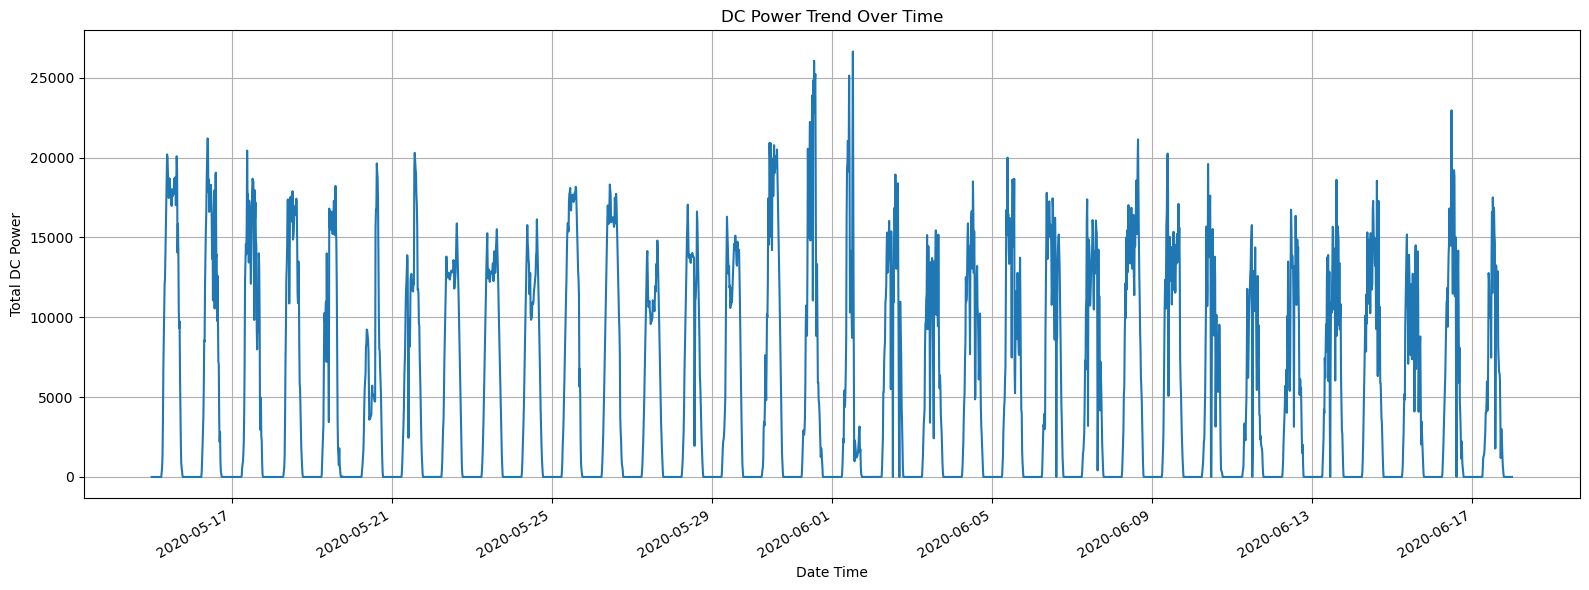

In [83]:
# --- DC Power Time Series Trend ---
fig, ax = plt.subplots(figsize=(16, 6))
merged_df.groupby('DATE_TIME')['DC_POWER'].sum().plot(ax=ax)
ax.set_title("DC Power Trend Over Time")
plt.xlabel("Date Time")
plt.ylabel("Total DC Power")
plt.grid(True)
plt.tight_layout()
plt.show()


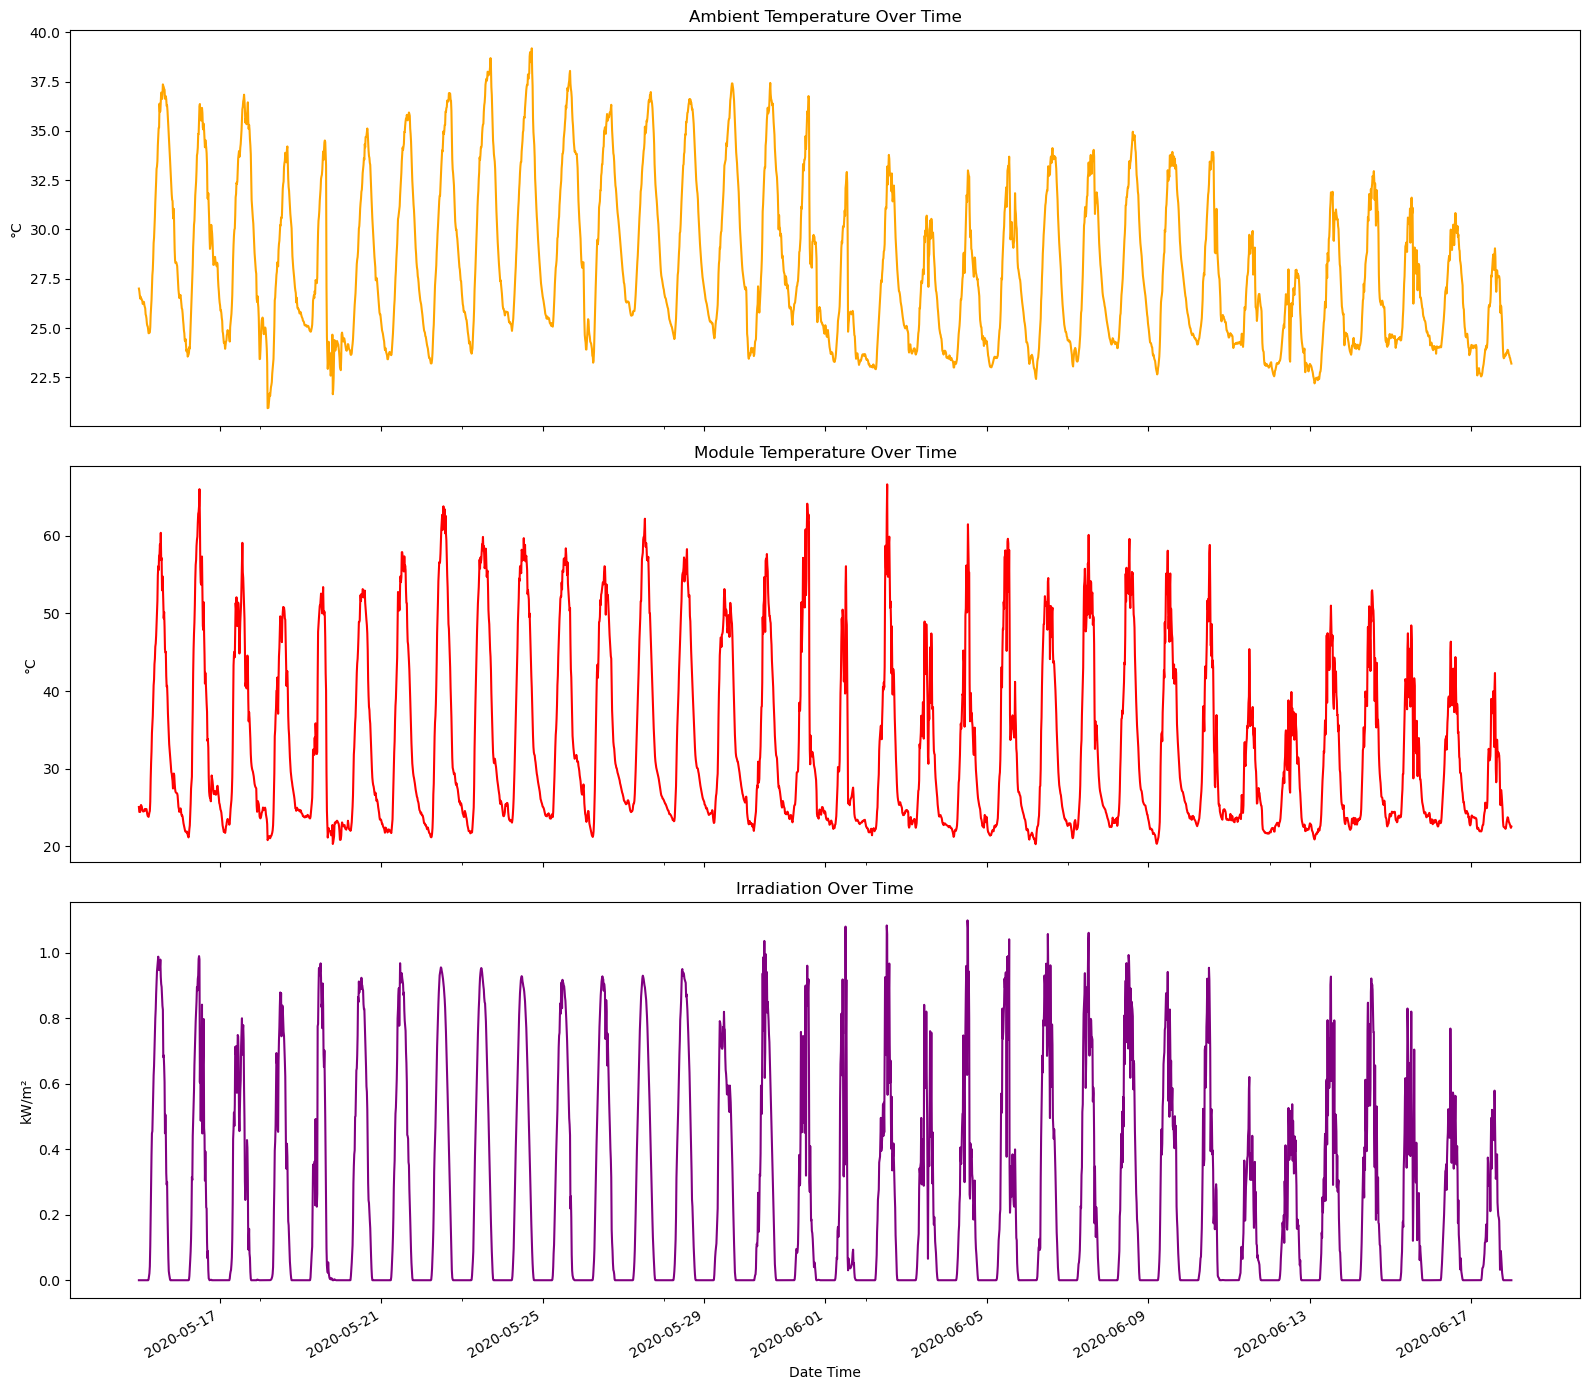

In [84]:
# --- Multiple Feature Trends Over Time ---
fig, axs = plt.subplots(3, 1, figsize=(16, 14), sharex=True)

merged_df.groupby('DATE_TIME')['AMBIENT_TEMPERATURE'].mean().plot(ax=axs[0], color='orange')
axs[0].set_title("Ambient Temperature Over Time")
axs[0].set_ylabel("°C")

merged_df.groupby('DATE_TIME')['MODULE_TEMPERATURE'].mean().plot(ax=axs[1], color='red')
axs[1].set_title("Module Temperature Over Time")
axs[1].set_ylabel("°C")

merged_df.groupby('DATE_TIME')['IRRADIATION'].mean().plot(ax=axs[2], color='purple')
axs[2].set_title("Irradiation Over Time")
axs[2].set_ylabel("kW/m²")

plt.xlabel("Date Time")
plt.tight_layout()
plt.show()


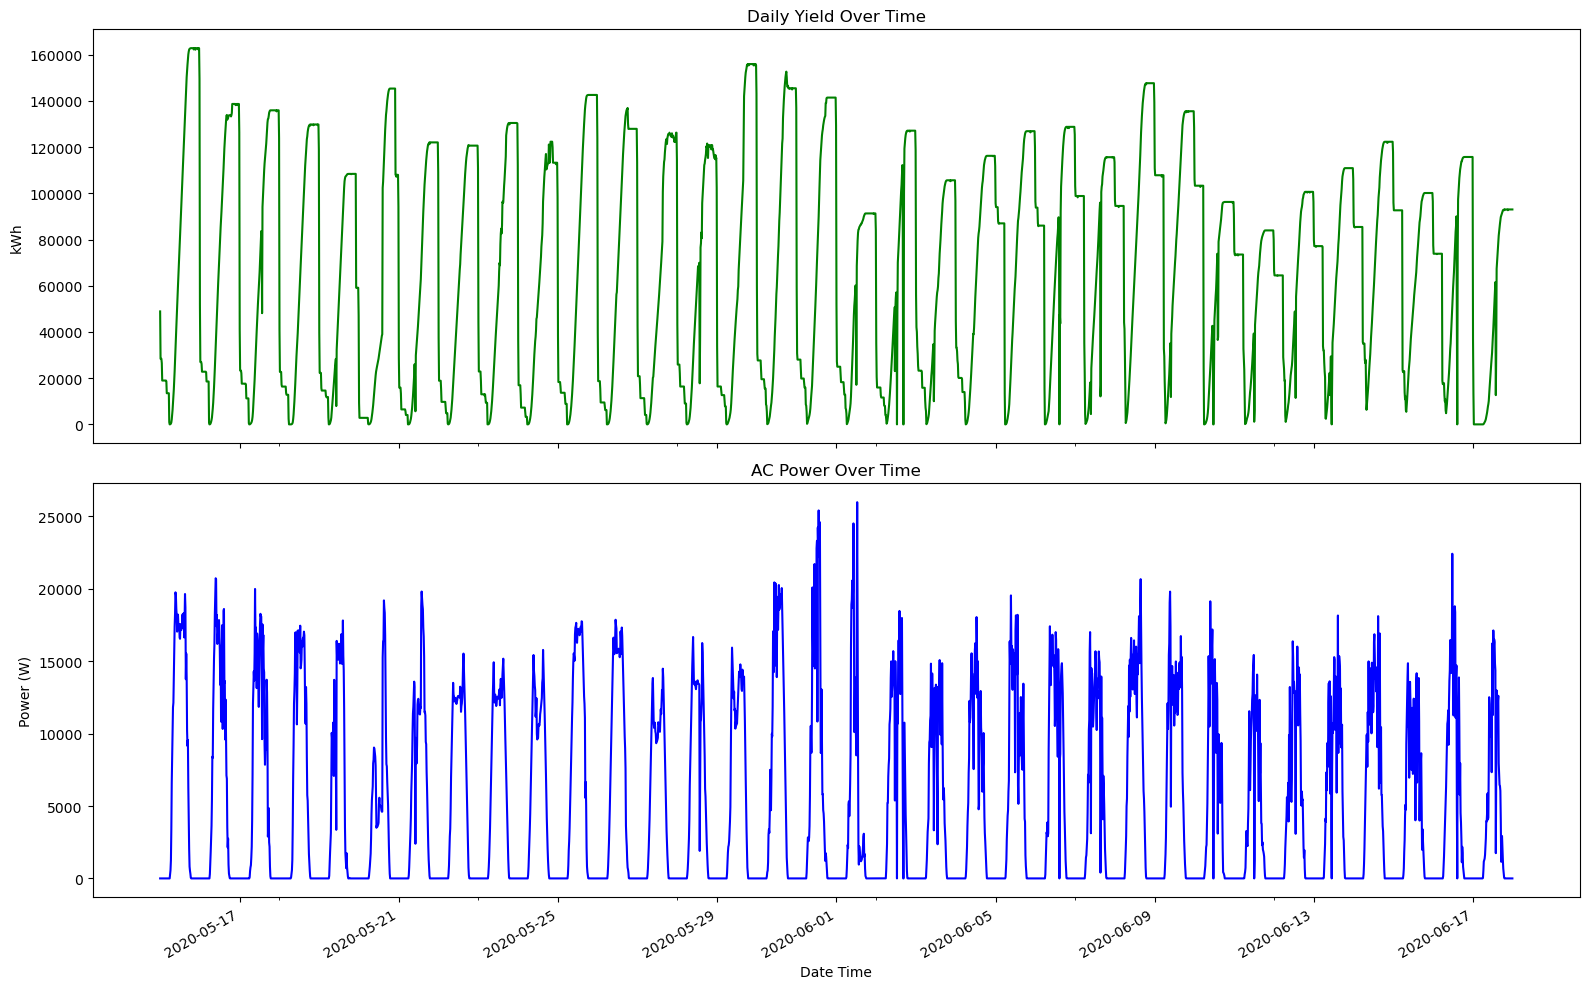

In [85]:
# --- DAILY_YIELD and AC_POWER Trends ---
fig, axs = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

merged_df.groupby('DATE_TIME')['DAILY_YIELD'].sum().plot(ax=axs[0], color='green')
axs[0].set_title("Daily Yield Over Time")
axs[0].set_ylabel("kWh")

merged_df.groupby('DATE_TIME')['AC_POWER'].sum().plot(ax=axs[1], color='blue')
axs[1].set_title("AC Power Over Time")
axs[1].set_ylabel("Power (W)")

plt.xlabel("Date Time")
plt.tight_layout()
plt.show()


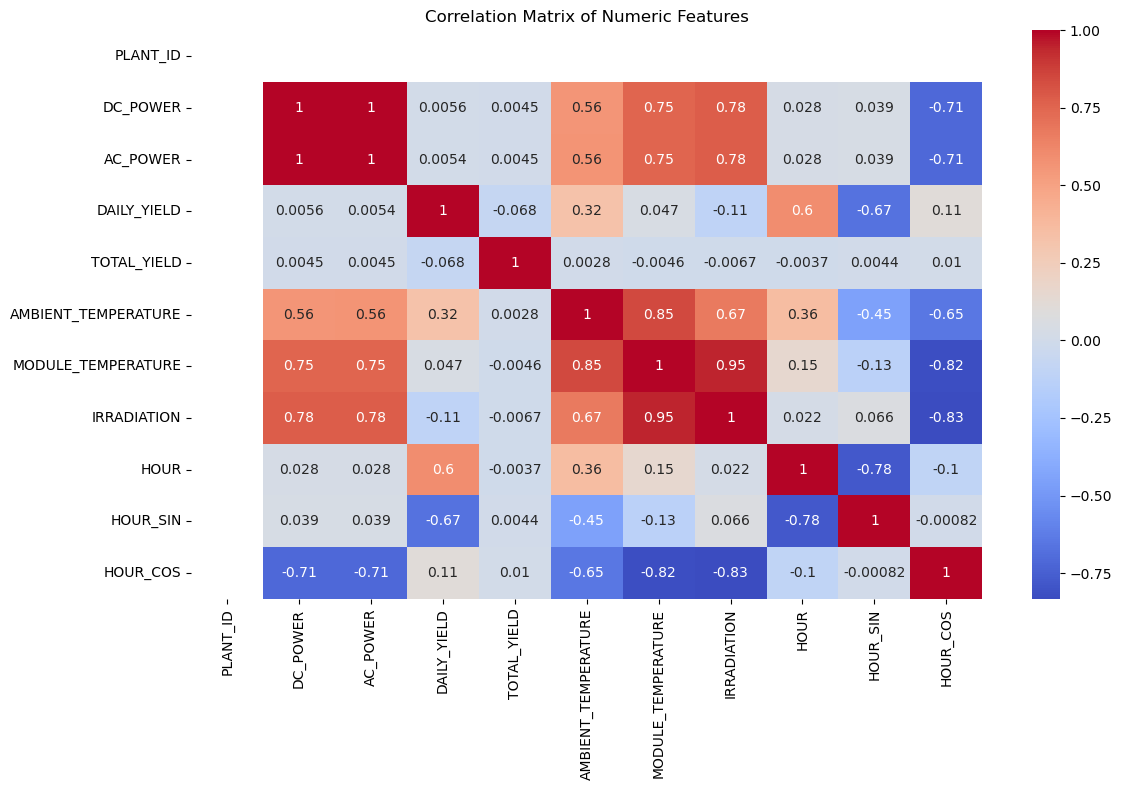

In [86]:
# --- Correlation Matrix for all numerical features ---
numeric_df = merged_df.select_dtypes(include='number')

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()


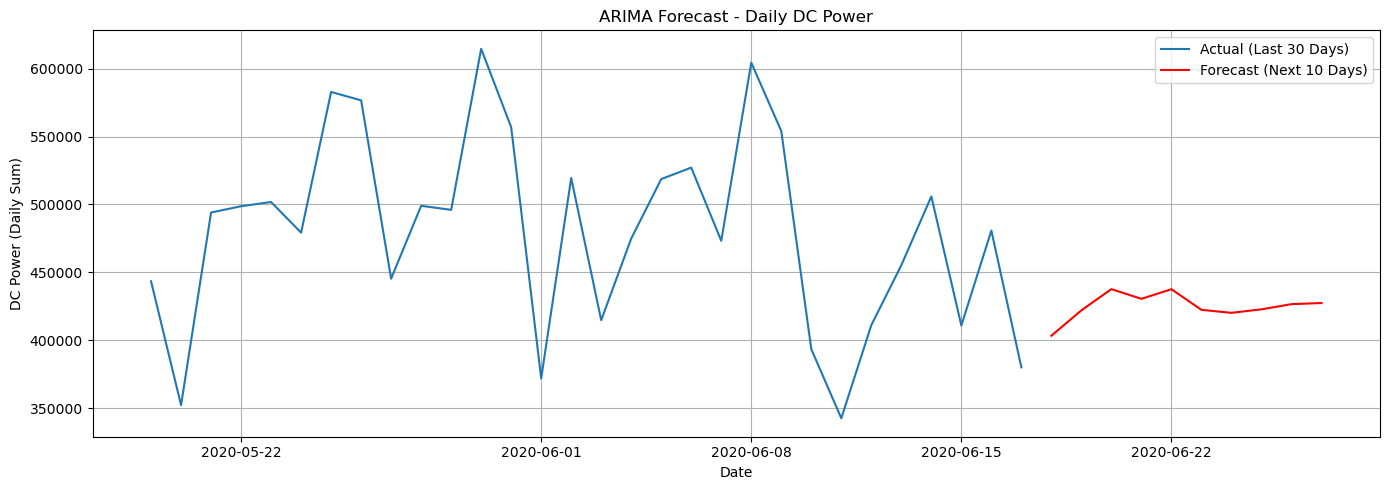

In [87]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Step 1: Resample to daily total DC power
ts_daily = merged_df.set_index('DATE_TIME').resample('D')['DC_POWER'].sum()

# Step 2: Fit ARIMA model on daily data
model_arima_daily = ARIMA(ts_daily, order=(5,1,0))  # Adjust (p,d,q) if needed
arima_result_daily = model_arima_daily.fit()

# Step 3: Forecast the next 10 days
forecast_daily = arima_result_daily.forecast(steps=10)

# Step 4: Plot actual vs forecast
plt.figure(figsize=(14, 5))
plt.plot(ts_daily[-30:], label='Actual (Last 30 Days)')
plt.plot(forecast_daily, label='Forecast (Next 10 Days)', color='red')
plt.title("ARIMA Forecast - Daily DC Power")
plt.xlabel("Date")
plt.ylabel("DC Power (Daily Sum)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


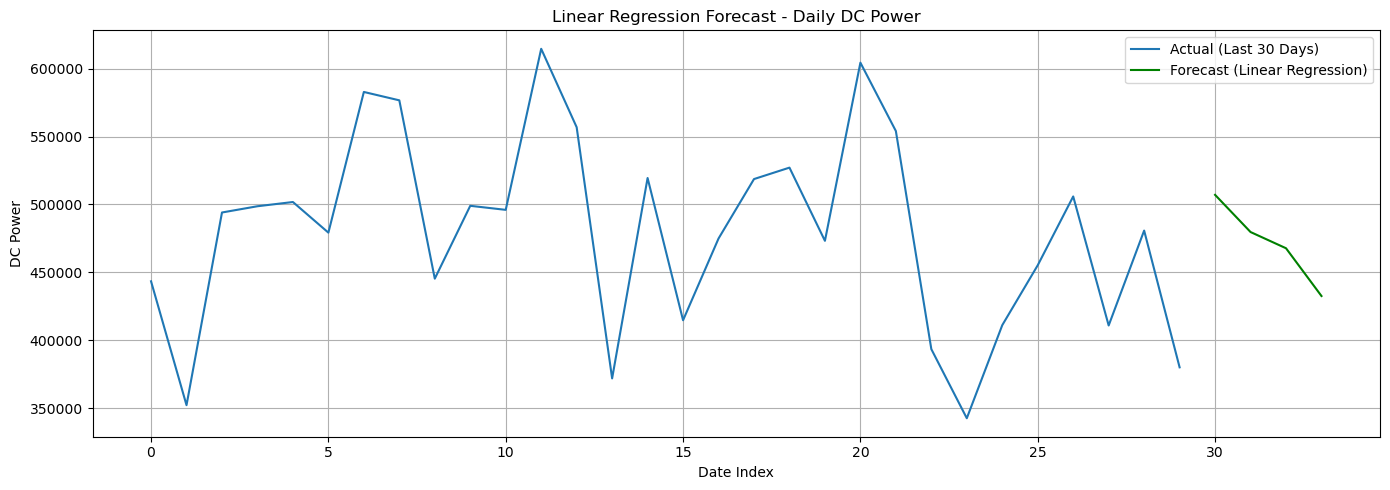

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Daily aggregation
daily_df = merged_df.copy()
daily_df['DATE'] = daily_df['DATE_TIME'].dt.date

# Aggregate: Mean weather features + total DC power
daily_features = daily_df.groupby('DATE')[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].mean()
daily_target = daily_df.groupby('DATE')['DC_POWER'].sum()

# Join features and target
daily_data = daily_features.join(daily_target)

# Add cyclical day features
daily_data['DAY_SIN'] = np.sin(2 * np.pi * np.arange(len(daily_data)) / 365)
daily_data['DAY_COS'] = np.cos(2 * np.pi * np.arange(len(daily_data)) / 365)

# Step 2: Split data
X = daily_data.drop('DC_POWER', axis=1)
y = daily_data['DC_POWER']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

# Step 3: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Step 5: Plot results
plt.figure(figsize=(14, 5))
plt.plot(y.values[-30:], label='Actual (Last 30 Days)')
plt.plot(range(len(y) - len(y_test), len(y)), y_pred_lr, label='Forecast (Linear Regression)', color='green')
plt.title("Linear Regression Forecast - Daily DC Power")
plt.xlabel("Date Index")
plt.ylabel("DC Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


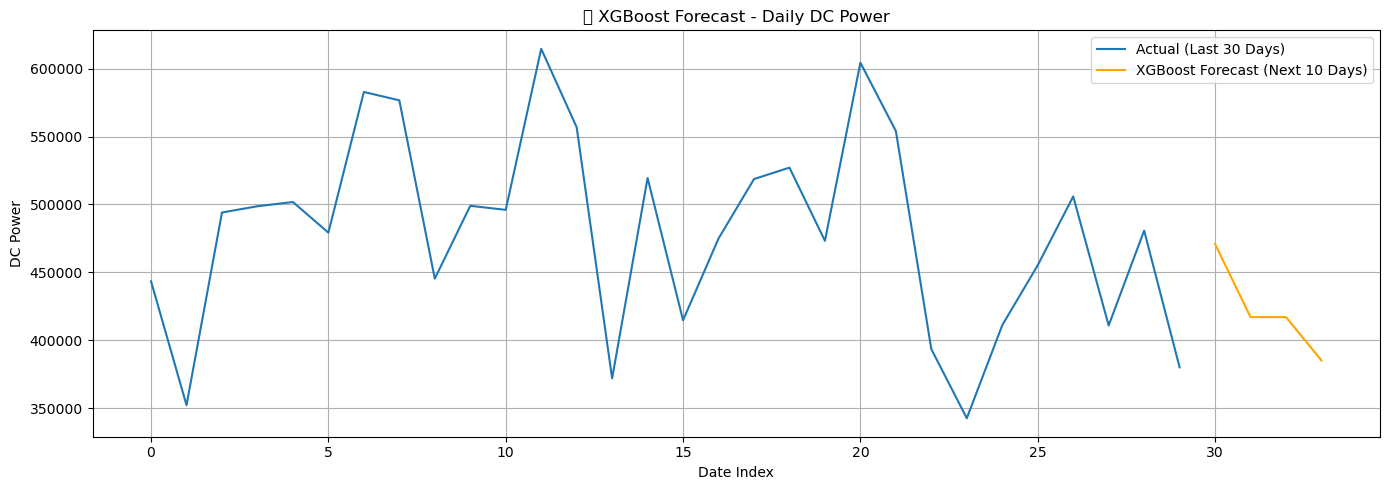

In [89]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Aggregate to daily level
daily_df = merged_df.copy()
daily_df['DATE'] = daily_df['DATE_TIME'].dt.date

# Daily average of weather and total of DC_POWER
daily_features = daily_df.groupby('DATE')[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].mean()
daily_target = daily_df.groupby('DATE')['DC_POWER'].sum()

# Combine features and target
daily_data = daily_features.join(daily_target)

# Add cyclical features
daily_data['DAY_SIN'] = np.sin(2 * np.pi * np.arange(len(daily_data)) / 365)
daily_data['DAY_COS'] = np.cos(2 * np.pi * np.arange(len(daily_data)) / 365)

# Step 2: Split into features (X) and target (y)
X = daily_data.drop('DC_POWER', axis=1)
y = daily_data['DC_POWER']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

# Step 3: Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Step 5: Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test_scaled)

import matplotlib.pyplot as plt

# Plot actual vs forecasted DC power
plt.figure(figsize=(14, 5))
plt.plot(y.values[-30:], label='Actual (Last 30 Days)')
plt.plot(range(len(y) - len(y_test), len(y)), y_pred_xgb, label='XGBoost Forecast (Next 10 Days)', color='orange')
plt.title("📈 XGBoost Forecast - Daily DC Power")
plt.xlabel("Date Index")
plt.ylabel("DC Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



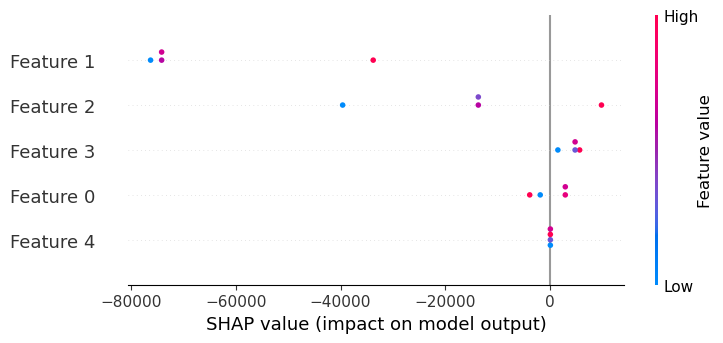

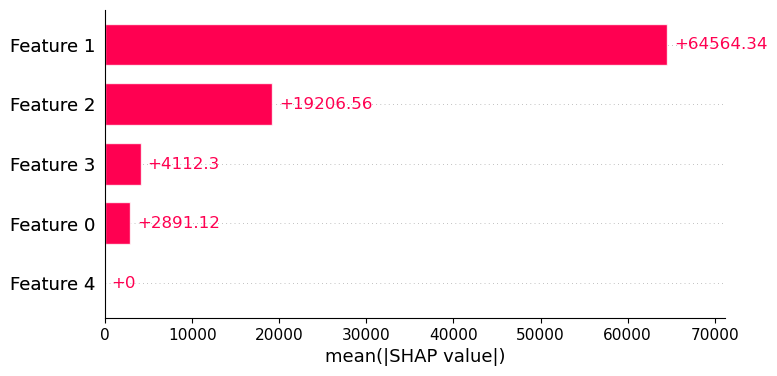

In [90]:
import shap

# SHAP initialization and computation
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_scaled)

# Beeswarm plot (most common SHAP plot)
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)



In [91]:
import lime
import lime.lime_tabular
import numpy as np

# Create LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X.columns.tolist(),
    mode='regression'
)

# Use a valid index within the range (0 to 3 in your case)
idx = 2  # You can change this to 0, 1, or 3

# Explain the selected prediction
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_scaled[idx],
    predict_fn=xgb_model.predict
)

# Show the explanation
lime_exp.show_in_notebook()


In [92]:
lgb_model = lgb.LGBMRegressor().fit(X_train, y_train)


# Create LIME explainer (if not already created)
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X.columns.tolist(),
    mode='regression'
)

# Use a safe index (0 to 3 based on your data size)
idx = 2

# ✅ Use the correct LightGBM model variable name (replace if different)
lime_exp_lgb = lime_explainer.explain_instance(
    data_row=X_test_scaled[idx],
    predict_fn=lgb_model.predict  # <- make sure this is your correct model variable
)

# Show the explanation
lime_exp_lgb.show_in_notebook()


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 30, number of used features: 0
[LightGBM] [Info] Start training from score 497443.252083
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

In [93]:
# Step 1: Create the LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X.columns.tolist(),
    mode='regression'
)

# Step 2: Choose a valid test index (between 0 and len(X_test_scaled)-1)
idx = 2  # you can change this to 0, 1, or 3 based on your test size

# Step 3: Generate the explanation for the XGBoost model
lime_exp_xgb = lime_explainer.explain_instance(
    data_row=X_test_scaled[idx],
    predict_fn=xgb_model.predict
)

# Step 4: Show the explanation (interactive in notebook)
lime_exp_xgb.show_in_notebook()

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- Linear Regression
y_pred_lr = lr.predict(X_test_scaled)

# --- LightGBM
y_pred_lgb = lgb_model.predict(X_test_scaled)

# --- XGBoost
y_pred_xgb = xgb_model.predict(X_test_scaled)

# --- ARIMA (align forecast length with y_test)
y_pred_arima = forecast_daily[:len(y_test)].values

# Ensure matching shapes
y_true_arima = y_test[:len(y_pred_arima)]

# Evaluation Metrics
metrics = {
    'Model': [],
    'MAE': [],
    'RMSE': [],
    'R²': []
}

def evaluate_model(name, y_true, y_pred):
    metrics['Model'].append(name)
    metrics['MAE'].append(round(mean_absolute_error(y_true, y_pred), 2))
    metrics['RMSE'].append(round(mean_squared_error(y_true, y_pred, squared=False), 2))
    metrics['R²'].append(round(r2_score(y_true, y_pred), 4))

# Run evaluations
evaluate_model("ARIMA", y_true_arima, y_pred_arima)
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("LightGBM", y_test, y_pred_lgb)
evaluate_model("XGBoost", y_test, y_pred_xgb)

# Convert to DataFrame
import pandas as pd
results_df = pd.DataFrame(metrics)
results_df.set_index("Model", inplace=True)
results_df


MAE      RMSE      R²
Model                                        
ARIMA              51757.28  61261.32 -0.4511
Linear Regression  33846.89  43727.41  0.2607
LightGBM           57194.43  73424.01 -1.0845
XGBoost            27465.26  36542.16  0.4837

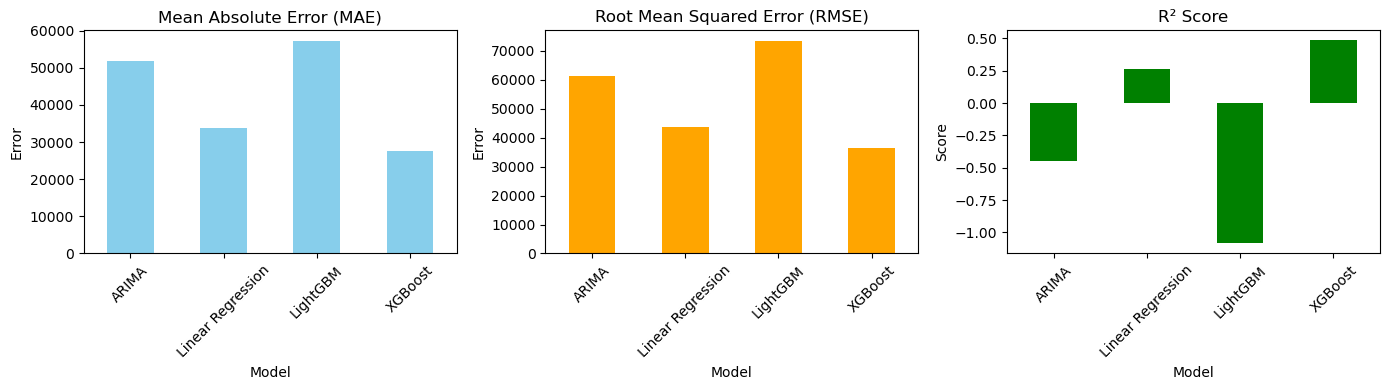


 Best Model Based on Evaluation Metrics:
Model: XGBoost
MAE: 27465.26
RMSE: 36542.16
R² Score: 0.4837


In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))

# MAE Plot
plt.subplot(1, 3, 1)
results_df['MAE'].plot(kind='bar', color='skyblue')
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('Error')
plt.xticks(rotation=45)

# RMSE Plot
plt.subplot(1, 3, 2)
results_df['RMSE'].plot(kind='bar', color='orange')
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('Error')
plt.xticks(rotation=45)

# R² Score Plot
plt.subplot(1, 3, 3)
results_df['R²'].plot(kind='bar', color='green')
plt.title('R² Score')
plt.ylabel('Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Identify Best Model
# ----------------------------
# Rank based on RMSE (lowest is best)
best_model = results_df.sort_values('RMSE').iloc[0]

print("\n Best Model Based on Evaluation Metrics:")
print(f"Model: {best_model.name}")
print(f"MAE: {best_model.MAE}")
print(f"RMSE: {best_model.RMSE}")
print(f"R² Score: {best_model['R²']}")


